In [ ]:
import torch
from torchvision import datasets, transforms

class one_hot():
    def __init__(self, num_class):
        self.num_class = num_class

    def __call__(self, y):
        return torch.eye(self.num_class)[y]

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:

transform = transforms.Compose([transforms.ToTensor()])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# 데이터로더 생성
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=64, shuffle=True, drop_last=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=64, shuffle=False, drop_last=True)

In [ ]:
import matplotlib.pyplot as plt

print(train_dataset[0][1])



5


In [ ]:
from torch import nn

class Encoder(nn.Module):
    def __init__(self, data_dim, hid_dim, hid_dim2 , lat_dim):
        super(Encoder, self).__init__()
        self.data_dim = data_dim
        self.hid_dim = hid_dim
        self.hid_dim2 = hid_dim2
        self.lat_dim = lat_dim


        self.net=nn.Sequential(nn.Linear(self.data_dim, self.hid_dim), nn.ReLU(),
                      nn.Linear(self.hid_dim , self.hid_dim2), nn.ReLU(),
                      )
        self.mu_net = nn.Linear(self.hid_dim2 , self.lat_dim)
        self.logvar_net = nn.Linear(self.hid_dim2, self.lat_dim)

    def reparameterization(self, mu, logvar):

        epsilon = torch.randn_like(logvar)
        z = mu+ epsilon*torch.exp(0.5*logvar)
        return z

    def one_hot(self, y):
        one_hot_y =[]
        for i in range(len(y)):
            a= torch.eye(10).to(y.device)
            one_hot=a[y[i]]
            one_hot_y.append(one_hot)
        result = torch.stack(one_hot_y , dim=0)
        return result.squeeze(dim=1)

    def forward(self, x, y):
        y= self.one_hot(y)
        cat = torch.cat([x, y], dim =1)
        x= self.net(cat)
        mu = self.mu_net(x)
        logvar = self.logvar_net(x)
        z = self.reparameterization(mu, logvar)

        return z, mu, logvar

class Decoder(nn.Module):
    def __init__(self,  lat_dim, hid_dim, hid_dim2, data_dim):
        super(Decoder, self).__init__()
        self.data_dim = data_dim
        self.hid_dim = hid_dim
        self.hid_dim2 = hid_dim2
        self.lat_dim = lat_dim


        self.net=nn.Sequential(nn.Linear(self.lat_dim, self.hid_dim), nn.ReLU(),
                      nn.Linear(self.hid_dim , self.hid_dim2), nn.ReLU(),
                      nn.Linear(self.hid_dim2 , self.data_dim))

    def one_hot(self, y):
        one_hot_y =[]
        for i in range(len(y)):
            a= torch.eye(10).to(y.device)
            one_hot=a[y[i]]
            one_hot_y.append(one_hot)
        result = torch.stack(one_hot_y , dim=0)
        return result.squeeze(dim=1)

    def forward(self, z, y):
        y= self.one_hot(y)
        cat = torch.cat([z, y], dim=1)
        x = self.net(cat)
        pred = nn.Sigmoid()(x)
        return pred

In [ ]:
import torch.nn.functional as F

epoch = 50

encoder = Encoder(28*28+10, 400, 200, 2).to(device)
decoder = Decoder(2+10, 200, 400, 28*28).to(device)

parameters = list(encoder.parameters()) + list(decoder.parameters())
optimizer = torch.optim.Adam(parameters, lr=0.001)

encoder.train()
decoder.train()

loss_stack = []

for i in range(epoch):
    loss_r =0
    for x_batch, y_batch in train_loader:
        x_batch = x_batch.view(64, -1).to(device)
        y_batch = y_batch.to(device)

        z, mu, logvar = encoder(x_batch, y_batch)

        recon_x_batch = decoder(z, y_batch)

        reconst_loss = nn.BCELoss(reduction='sum')(recon_x_batch, x_batch)
        regular_loss = 0.5 * torch.sum(mu**2 + torch.exp(logvar) - logvar - 1)


        loss = reconst_loss + regular_loss
        loss_r += loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    real_loss  = loss_r /len(train_dataset)
    loss_stack.append(real_loss)

    print(f" For epoch{i+1}, Loss : {real_loss}")
    print("-"*30)

 For epoch1, Loss : 158.5991668701172
------------------------------
 For epoch2, Loss : 137.76327514648438
------------------------------
 For epoch3, Loss : 134.66915893554688
------------------------------
 For epoch4, Loss : 133.04840087890625
------------------------------
 For epoch5, Loss : 132.0364990234375
------------------------------
 For epoch6, Loss : 131.31912231445312
------------------------------
 For epoch7, Loss : 130.7124481201172
------------------------------


KeyboardInterrupt: ignored

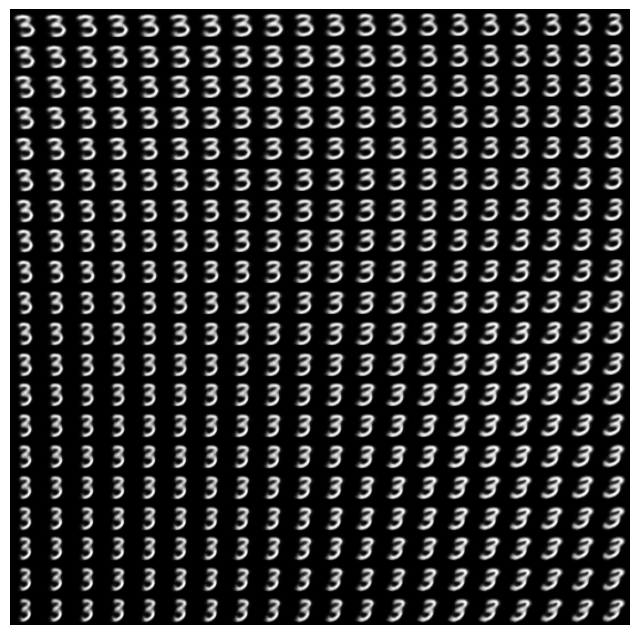

In [ ]:
with torch.no_grad():

    # x, y 각각에 대해 -1부터 1까지 0.1 간격으로 균일하게 숫자를 생성
    x_values = torch.linspace(-1, 1, 20).to(device)
    y_values = torch.linspace(-1, 1, 20).to(device)

    # 생성된 x_values와 y_values를 조합하여 2차원 텐서 생성
    grid_tensor = torch.stack(torch.meshgrid(x_values, y_values), dim=-1)

    # 2차원 텐서를 flatten하여 최종 결과 텐서 생성
    result_tensor = grid_tensor.view(-1, 2)
    a= torch.full((400, 1), 3)

    a=a.to(device)
    sampled_images = decoder(result_tensor, a).view(400, 28, 28)

    # Inference 결과 시각화
    fig = plt.figure(figsize=(8, 8))
    for idx, img in enumerate(sampled_images):
        ax = fig.add_subplot(20, 20, idx+1)
        img = img.cpu()
        img = img.detach().numpy()
        ax.imshow(img, cmap='gray')
        ax.axis('off')
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()